# Inferential linear regression
## Objectives
- State the assumptions of the linear regression model:
    - Model is linear
    - Observations are independent
    - Errors have constant conditional variance
    - Errors are normally distributed
- Use $p$-values associated with $\beta$ coefficients for NHST

In [1]:
%matplotlib inline

from math import ceil
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
font = {'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
plt.style.use('ggplot')

## Linear Regression Assumptions and Inference

Linear regression can be used for **inference**.

What is inference? Dictionary says "a conclusion reached on the basis of evidence and reasoning."

To accomplish this, we need a better understanding of the probabilistic nature of linear regression, i.e., how we can think about linear regression as a **statistical model**.

Let's now go back to that topic, and see what additional assumptions and checks we must make to use linear regression in this way.

## Statistical Models 

Our working definition of **statistical model** as a catalog of ways we believe the data could have been generated, and **fitting a statistical model** as combining this catalog with data to determine a single option from this catalog that we most believe generated the data we actually have.

We developed the **maximum likelihood principle** as a way to make the procedure of choosing the "best" option from the catalog.

So far our discussion of regression has not followed this line.  Instead we viewed it as simply fitting a line or curve to data, with the success of this judged on how well predictions from that line or curve held up on test data.

## The Linear Regression Assumptions

Linear regression is often presented along with a list of assumptions.

### The Linear Regression Assumptions:

  - Linearity
  - Independence
  - Homoscedasticity
  - Normal Distribution of Errors
  
These assumptions are not all needed, nor must they all be checked, for all applications of linear regression.  Indeed, when used as a **predictive** model, only the first is really needed (though some of the others bear consequences when blatantly violated).

We will take these assumptions in turn, and discuss what the assumption means, and what can happen when it is violated.

## The Linearity Assumption

The "linear" in the name "linear regression" does **not** mean that the model is attempting to fit a linear function of the **raw features**.  Instead, it means that the model is a linear function of the **transformed features**.

So, the **linearity assumption** in regression says that the **model fits the data well**; that is, that $y$ is a **linear function of the (possibly transformed) features in the model**.  Of course, $y$ cannot be an exact linear function, because there is some randomness involved, but this should be the **only reason** that $y$ is not a linear function of the features.

$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_k x_k + \text{noise} $$

**Question:** What do I mean when I say, $y$ is a linear combination of $x_1$, $x_2$, and $x_3$?

The residuals vs. feature plots can be used to assess this asumption.

In [2]:
np.random.seed(1)
n = 500  
x = np.random.uniform(-2, 4, size=n)
y = 1 + x - 0.5 * x * x + np.random.normal(size=n)

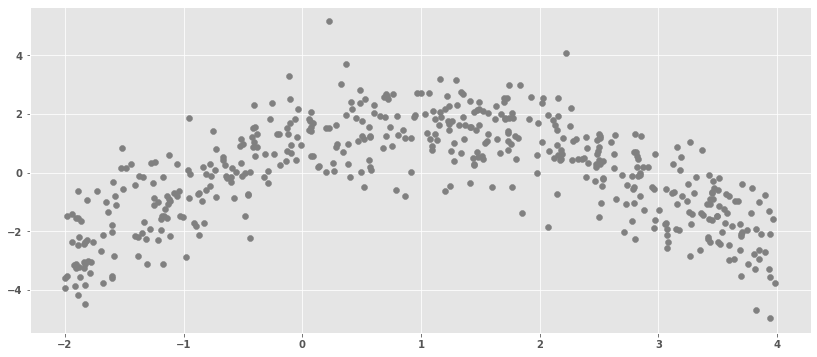

In [3]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(x, y, color="grey");

Notice how this data looks like it fits some kind of relationship like:
    
$$ y \mid x = \beta_0 + \beta_1 x + \beta_2 x^2 + \text{noise} $$

We just don't know what the numbers $\beta_0, \beta_1, \beta_2$ are.  This is a **description of how the data was generated**, and so meets our definition of a statistical model.  

By using a quadratic transformation of the predictor, we can fit this model to our data.

In [4]:
X = np.empty((len(x), 2))
X[:, 0] = x
X[:, 1] = x**2

# This model is built using sklearn
quadratic_model = LinearRegression()
quadratic_model.fit(X, y)

y_hat = quadratic_model.predict(X)

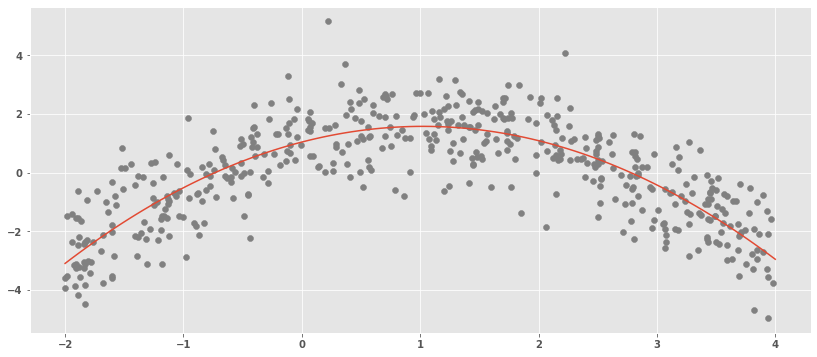

In [5]:
# plot model versus data 
fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(x, y, color="grey")
xvals = np.linspace(-2,4,100)
Xfeatures = np.empty((len(xvals), 2))
Xfeatures[:,0] = xvals
Xfeatures[:,1] = xvals *xvals
ax.plot(xvals,quadratic_model.predict(Xfeatures) );

The residual plots show no obvious pattern, which is a hint that we specified our statistical model correctly. 

In [6]:
def residual_plot(ax, x, y, y_hat, n_bins=50):
    residuals = y - y_hat
    ax.axhline(0, color="black", linestyle="--")
    ax.scatter(x, residuals, color="grey", alpha=0.5)
    ax.set_ylabel("Residuals ($y - \hat y$)")
    ax.set_xlabel("x")
    ax.set_title("Residuals Plot")

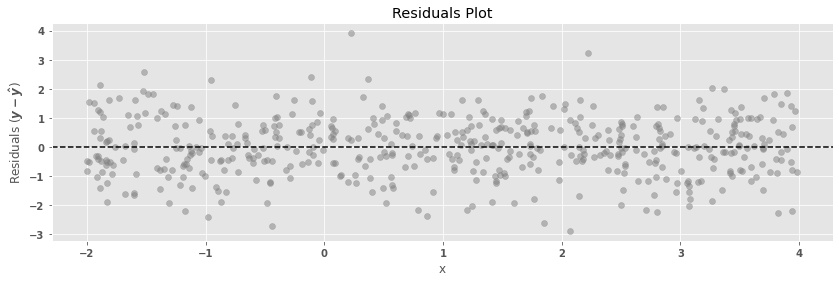

In [7]:
fig, ax = plt.subplots(figsize=(14, 4))
residual_plot(ax, x, y, y_hat)

If we had instead used the model

$$ y \mid x = \beta_0 + \beta_1 x + \text{error} $$

we would end up with a residual plot containing an obvious pattern, which is a hint that we have **misspecified** our statisical model.

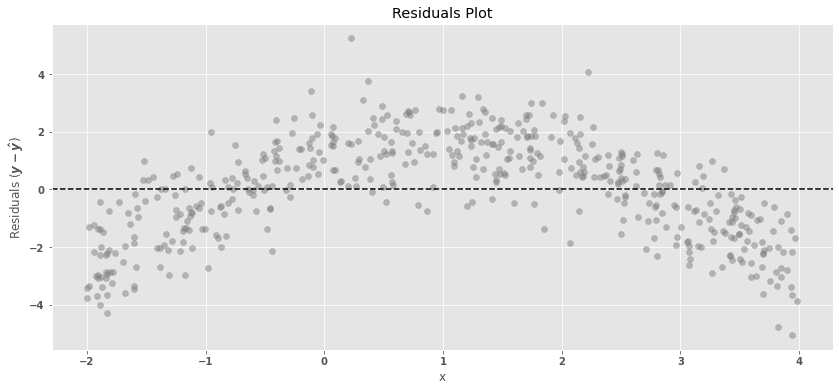

In [8]:
linear_model = LinearRegression()
linear_model.fit(x.reshape(-1, 1), y)

y_hat = linear_model.predict(x.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(14, 6))
residual_plot(ax, x, y, y_hat)

We clearly do not have a band evenly spaced around the center line. This type of plot indicates that something is missing from the model.

The linearity assumption for linear regression is essentially the desire that **the model we fit to our data is well specified, i.e., it countains the true (or close to the true) process that generated the data.**

## QQ Plots 

Below I illustrate another test to assess the assumption that our data has a linear relationship with our input features and our error is norally distributed.  Q-Q (Quantile-Quantile) plots compare the quantiles of the assumed theoretical distribution(x-axis) and the actual quantiles(-axis).

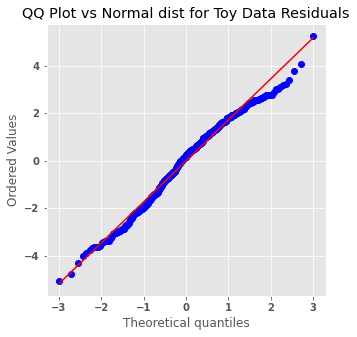

In [9]:
fig, ax = plt.subplots(figsize=((5, 5)))
stats.probplot(y - y_hat, plot=ax);
ax.set_title("QQ Plot vs Normal dist for Toy Data Residuals");
# Note: y-axis below is actual quantiles from data 
# x-axis is theoretical quantiles given and assumed normal distribution

## Consistency: The Independence Assumption

The **consistency** of linear regression adresses the effect of gathering more data.  We would like the regression to become more and more accurate as we feed it more training data.

But accurate with reference to what?

The idea is this:  if our data we **truly** generated from a random process like this:

$$ y \mid X \sim \beta_0 + \beta_1 x_1 + \cdots + \beta_k x_k + \text{noise} $$

Then the coefficeints we get from fitting a linear regression can be considered as **estimates of the true parameters**:

$$ \underbrace{\hat \beta_k}_{\text{The Coefficients from the Fit Regression}} \overbrace{\approx}^{\text{Are approximations of}} \underbrace{\beta_k}_{\text{The True Parameters}} $$

**Consistency** is the statement that this approximation gets **better** as we collect more data.

In [10]:
##  Generates both the data and fitting a LR model num=50 times for dataset size = n   
def plot_regressions(ax, n, num=50):
    for k in range(num):
        x = np.random.uniform(-1, 1, size=n)
        y = 2*x + np.random.normal(0.0, 1.0, size=n)
        # the first round plot the observations
        if k == 0:
            ax.scatter(x, y, color="grey", s = 50)
        # fitting model to the data
        model = LinearRegression()
        model.fit(x.reshape(-1, 1), y)
        
        t = np.linspace(-1, 1, num=250)
        ax.plot(t, model.predict(t.reshape(-1, 1)),
                color="grey", alpha=0.2)

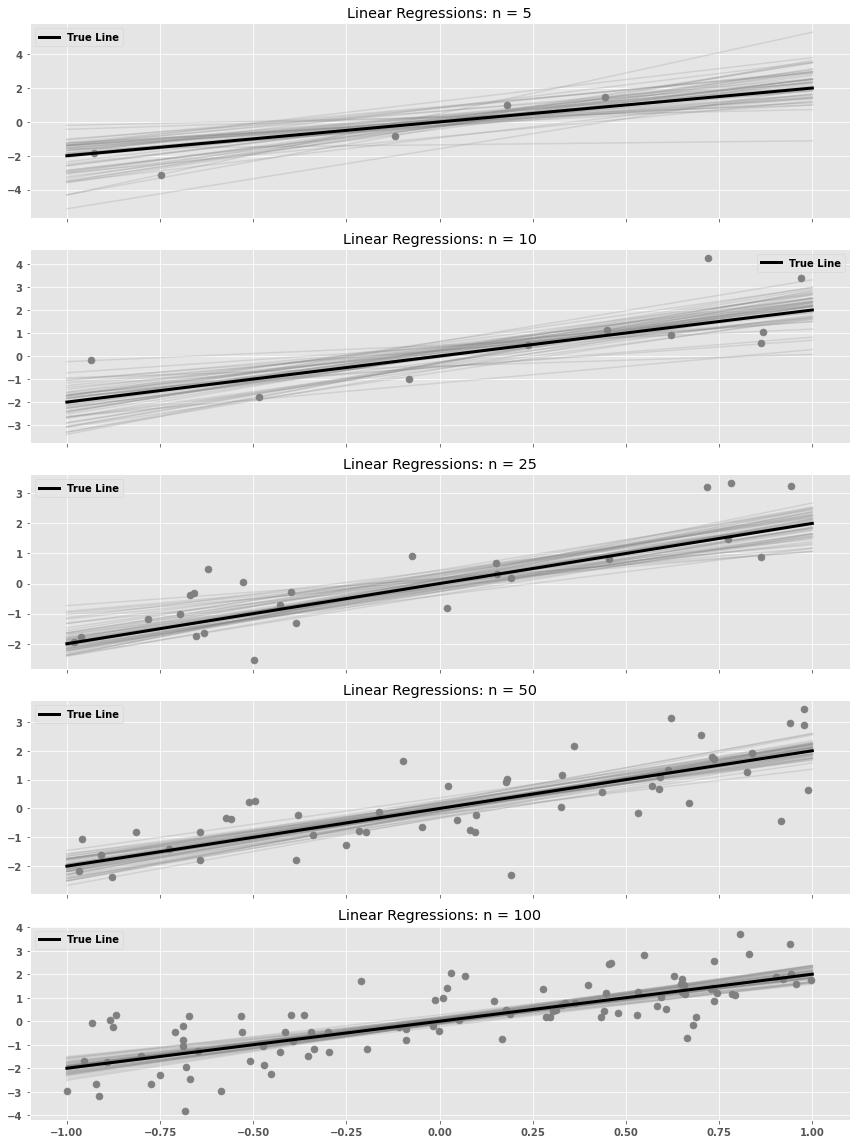

In [11]:
# below I will vary n, the sample size for generating a LR model
ns = [5, 10, 25, 50, 100] ## different sample sizes

fig, axs = plt.subplots(len(ns),
                        figsize=(12, 16), 
                        sharex=True)

for ax, n in zip(axs, ns):
    plot_regressions(ax, n)
    ax.plot([-1, 1], [-2, 2], color="black", linewidth=3, label="True Line")
    ax.set_title(f"Linear Regressions: n = {n}")
    ax.legend()
fig.tight_layout()

Linear regression is consistent as long as the **data** are independent.  That is, each sampled data point $(X, y)$ must be independent from all other data points.  When data are independent, each additional data point gives us **more information**, which allows us to better estimate the regression line.

As an example of how this assumption can be violated, consider data that is generated from an iterative procedure like:

$$ y_k = y_{k-1} + \text{error} $$

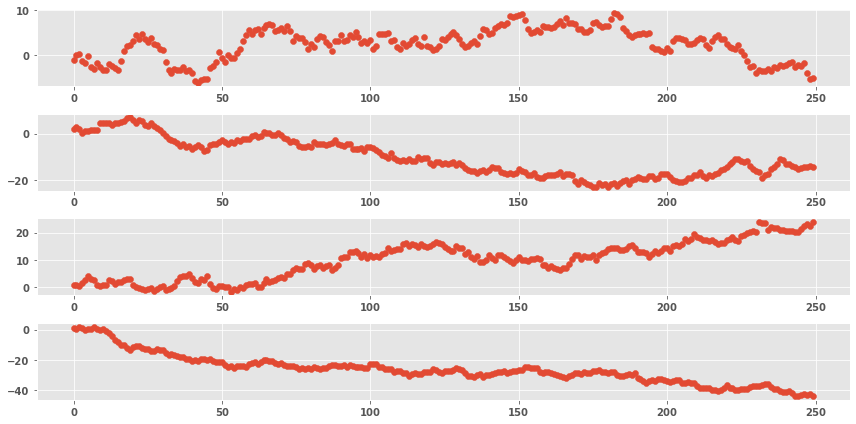

In [12]:
np.random.seed(123)
n_walks = 4 ## random walks

fig, axs = plt.subplots(4, figsize=(12, 6))

n = 250
x = np.arange(n)
for ax in axs.flatten():
    y = np.random.normal(size=n)
    walk = np.cumsum(y)
    ax.scatter(x, walk)
    
plt.tight_layout()

This type of data is often called **time series** data, and it is *not* independently sampled.

## Normality of Errors: Distribution of Parameter Estimates

The **most information we could possibly have** about the probabalistic nature of linear regression is to know the **distribution of the parameter estimates / coefficients**.

### What This Means

It's important to understand what this means.

The parameter estimates / coefficients from a fit linear regression are **random generated**.  If we have different sample of data from our population, fitting a linear regression will give us slightly different results. So...

$$ \hat \beta \text{ is a random variable!} $$

**Note:** We have already observed that when the data is independent, more data will cause these different results to converge to the same answer.  This is consistency!

The most we could ask for is a complete description of the distribution of the coefficients.  This is available in some circumstances, but it **requires very stringent assumptions**!

In [13]:
def run_one_regression(n, noise=np.random.normal):
    ''' run regression on y ~ x1+x2+x3
            where y is not dependent on x3
    '''
    x1 = np.random.uniform(-1, 1, size=n)
    x2 = np.random.uniform(-0.5, 0.5, size=n)
    x3 = np.random.uniform(-2, 2, size=n)
    ## assuming you have three features available
    ##   but the ground truth is that y is only dependent on x1 & x2
    ##   in other words, x3 is a distraction
    y = 1 + x1 - 2*x2 + noise(size=n)
    X = np.empty(shape=(n, 3))
    X[:, 0] = x1; X[:, 1] = x2; X[:, 2] = x3
    model = LinearRegression()
    model.fit(X, y)
    return X, y, model.coef_

def simulate_many_coeffs(n, n_sim=5000, noise=np.random.normal):
    '''simulate n_sim samples
        calcuate and return the coefficients'''
    coeffs = np.empty(shape=(n_sim, 3))
    for i in range(n_sim):
        _, _, coeffs[i, :] = run_one_regression(n, noise=noise)
    return coeffs

def plot_paramter_estimate_histograms(axs, coeffs):
    true_beta = [1, -2, 0]
    for i, ax in enumerate(axs):
        axs[i].hist(coeffs[:, i], bins=100, color="grey", alpha=0.5, 
                density=True, label="Parameter Estimates: Observed")
        axs[i].set_title(r"Distribution of $\hat \beta_{}$".format(i+1)) ## _1
        axs[i].axvline(true_beta[i], color="black", label=r"True Parameter $\beta_{}$".format(i+1))
        axs[i].legend()

In [14]:
X, y, _ = run_one_regression(100, noise=np.random.normal)
coeffs  = simulate_many_coeffs(100, noise=np.random.normal)

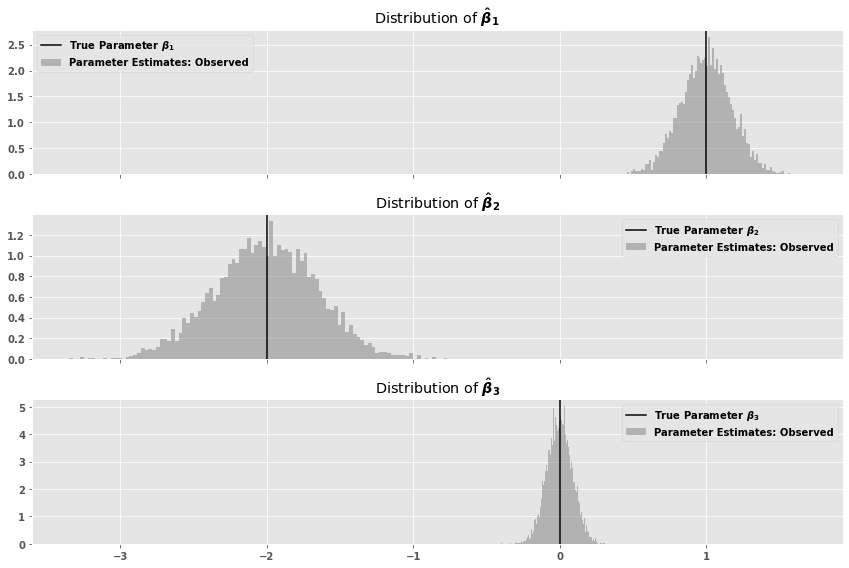

In [15]:
fig, axs = plt.subplots(3, figsize=(12, 8), sharex=True)
plot_paramter_estimate_histograms(axs, coeffs)
fig.tight_layout()

The usual assumption / consequence is this:

**When the noise is assumed to be normally distributed (centered at zero, variance does not depend on x), then the parameter estimates are ALSO normally distributed**.

We can write that assumption in rigorous notation as:

$$ y \mid x \sim \beta_0 + \beta_1 x_1 + \cdots + \beta_k x_k + \text{Normal}(0, \sigma^2) $$

$\sigma$ here must **NOT depend on $x$**.  This specific property is called [**homoscedasticity**](https://en.wikipedia.org/wiki/Homoscedasticity).

English, please!!! Ancient Greek *homo- = same* and *skedas = dispersion*. 

**Non-homoscedastic** or [**heteroscedastic**](https://en.wikipedia.org/wiki/Heteroscedasticity) data has a conditional variance that changes as the feature changes.  For example, if we generate data from a process like

$$ y \mid x \sim \beta_0 + \beta_1 x_1 + \cdots + \beta_k x_k + \text{Normal}(0, x^2) $$

In [16]:
x = np.random.uniform(low=1.0, high=5.0, size=500)
y2 = 1 + 5*x + np.random.normal(scale=x)  # pulling noise that is proportional to x value 

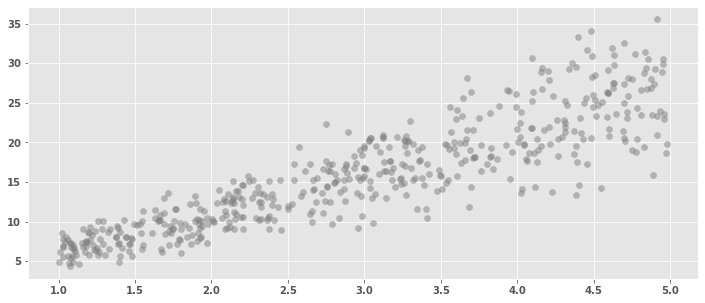

In [17]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(x, y2, color="grey", alpha=0.5);

When this happens, it can lead to increased Type I error rates or decreased statistical power. The topic of **Generalized Linear Models** addresses statistical inference  when data is heteroscedastic.  

### The Mean of the Parameter Estimate Distributions

As is evident from the plots above, the **mean** of the parameter estimate distributions **is the true parameters**.  This is nice!  This property is called **unbiasedness**.

### The Variance of the Parameter Estimate Distribution

The variance of the parameter estimate distribution is not so easy to describe, but it is computable.

The variance of $\hat \beta_k$ can be found as the $(k, k)$-th entry (i.e., the $k$-th diagonal entry) in the matrix:

$$\DeclareMathOperator{\Var}{Var}
\Var(\hat \beta) = \sigma^2 (X^t X)^{-1} $$

<!--
---
How do you arrive here? Hopefully, you remember the following
1. $\text{Var}(X) = E[(X - E[X])^2] = E[X^2] - E[X]^2$ (you are expected to know this by heart now)
2. $\beta$ is the parameter, and $\hat \beta$ is an unbiased estimate, which means $E[\hat \beta] = \beta$.
3. $X \perp \varepsilon$, and $\epsilon \sim N(0, \sigma^2)$
4. in vector/matrix form, 
\begin{align}
y = X\beta + \varepsilon \quad \Longrightarrow \quad 
E[y] & = E[X\beta + \varepsilon]\\
     & = E[X\beta] + E[\varepsilon] \quad \text{ why?}\\
     & = \beta E[X] + 0 \quad\quad \text{ why? & why?}\\
     & = \beta E[X]
\end{align}
5. we also know $\hat \beta = (X'X)^{-1}X'y$, this is called ordinary least squares (OLS) solution of the **normal equation** $X^T y = X^T X \beta$ (what's so normal about it? because $y - X\beta$ is normal to the range of $X$. Wait, what? Yup, in linear algebra, normal means perpendicular, remember the vectors)
6. Then what is $\beta$?
$$
X\beta = y - \varepsilon 
\Longrightarrow 
X'X\beta = X'(y-\varepsilon) 
\Longrightarrow 
\beta = (X'X)^{-1} X'(y-\varepsilon)
$$

Okay, I gather pretty much everything I need, I'm gonna derive the monster $\Var(\hat \beta)$:
\begin{align}
\Var(\hat \beta)
& = E[(\hat\beta - \beta)(\hat\beta - \beta)^T]\\
& = E[((X'X)^{-1}X'y - (X'X)^{-1} X'(y-\varepsilon))((X'X)^{-1}X'y - (X'X)^{-1} X'(y-\varepsilon))^T]\\
& = E[((X'X)^{-1}X'\varepsilon)((X'X)^{-1}X'\varepsilon)^T]\\
& = E[((X'X)^{-1}X'\varepsilon\varepsilon'X(X'X)^{-1}]\\
& = E[\varepsilon\varepsilon']\, ((X'X)^{-1}X'X(X'X)^{-1} \\
& = \sigma^2\,(X'X)^{-1} 
\end{align}

---
-->
Now that we have and equation for the variance of $\hat\beta$ computed, we can then plot the density and see if the distribution matches

In [18]:
# Creating X in equation 
# We need X to have an intercept column for this to be valid...
X_with_intercept = np.zeros((X.shape[0], X.shape[1] + 1))
X_with_intercept[:, 0] = 1.0
X_with_intercept[:, 1:] = X

# computing inverse of X.T @ X 
S = np.linalg.inv(X_with_intercept.T @ X_with_intercept)

In [19]:
# Adding a function to plot analytical probability distributions of beta
def plot_coefficient_distributions(axs, means, variances):
    t = np.linspace(-4, 4, num=250)
    for ax, mu, sigma_sq in zip(axs, means, variances):
        dist = stats.norm(mu, np.sqrt(sigma_sq))
        ax.plot(t, dist.pdf(t), 
                color="black", linestyle="--",
                label="Parameter Estimates: Theoretical")
        ax.legend()

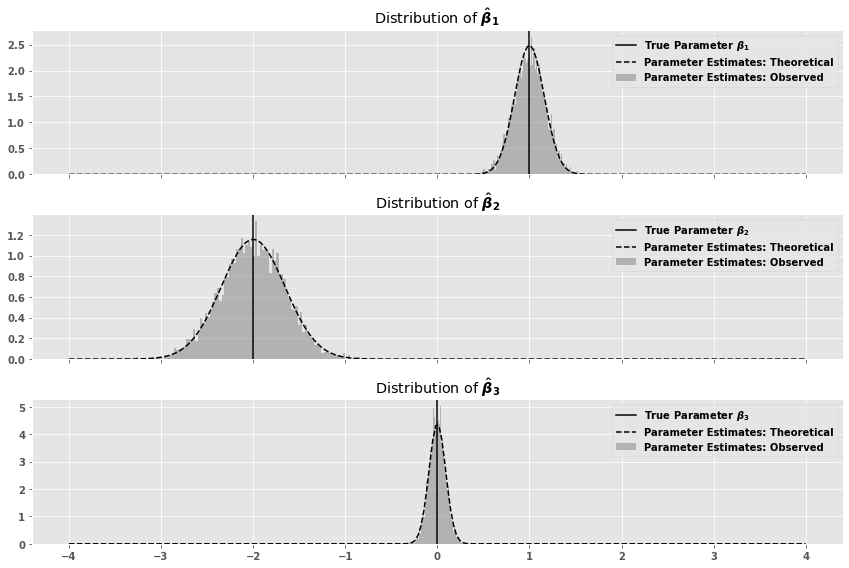

In [20]:
fig, axs = plt.subplots(3, figsize=(12, 8), sharex=True)

plot_paramter_estimate_histograms(axs, coeffs)
plot_coefficient_distributions(axs, [1, -2, 0], np.diagonal(S)[1:]) # note: original variance=1

fig.tight_layout()

## Applications to Inference

The most common application of all these ideas is in the hypothesis testing of regression coefficients.

Let's use our model of insect wing sizes to answer an inferential question: 

> Does continent have any effect on wing size?

To accomplish this, we need to pre-sepcify a regression model relating the wing size of insects to all other relevent measurement.  Another instructor has already done some work, Below is their final model:

$$ \text{Wing Span} \approx a + b \times \text{Latitude} + c \times \text{Latitude}^2 +  d \times \text{Sex} + e \times \text{Continent} $$

We are still unsure if we need continent as a feature of our data, so we want to do a statistical test to see if its needed.  **If $e$ is zero, or close to zero, then continent has no effect on wing span**.

Let's reload the data:

In [21]:
insects = pd.read_csv('./data/insects.csv', sep='\t')
insects.head()

,continent,latitude,wingsize,sex
0,1,40.5,941.111111,0
1,1,42.0,924.444444,0
2,1,43.6,924.204444,0
3,1,45.7,915.217778,0
4,1,45.9,905.471111,0


Let's estimate the model:

In [22]:
insects_model_quad_with_continent = smf.glm(
    data = insects,
    formula='wingsize ~ latitude + I(latitude**2) + sex + continent',family= sm.families.Gaussian())
mod = insects_model_quad_with_continent.fit()

mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               wingsize   No. Observations:                   42
Model:                            GLM   Df Residuals:                       37
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                          125.48
Method:                          IRLS   Log-Likelihood:                -158.41
Date:                Wed, 04 Nov 2020   Deviance:                       4642.6
Time:                        12:09:23   Pearson chi2:                 4.64e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1945.3896     91.505     21.260      0.000    1766.043    2124.736
latitude           -42.9562      3.883    -11.062      0.000     -50.567     -35.345
I(latitude ** 2)     0.4477      0.041     10.953      0.000       0.368       0.528
sex                -89.9019      3.811    -23.593      0.000     -97.371     -82.433
continent           -4.1069      3.580     -1.147      0.251     -11.124       2.911
====================================================================================
"""

Those `standard errors` are what we computed with our $\sigma^2 (X^t X)^{-1}$ calculation.

## Linear Regression p-values

Recall that a **p-value** describes the amount of surprise that we feel when observing data, given that we are taking a skeptical stance on how that data is generated.

$$ P(\text{Observing A Statistic Equal or More Extreme than Actual} \mid H_0) $$

So to make sense of the p-values here, we need to describe the **null hypothesis** and the **statistic**.

The **null hypothesis** in this case is that each value of $y$ was generated by sampling from a relationship like:

$$ H_0: \quad 
y \mid x \sim N(a + b \times \text{Latitude} + c \times \text{Latitude}^2 +  d \times \text{Sex} + 0 \times \text{Continent}, \sigma^2) $$

Notice that in the null hypothesis, we are assuming **the effect of continent is zero, so we would be surprised to find it very non-zero**.

Given this null hypothesis, the **p-value** reported in linear regression is

$$ P(\text{Observe a Parameter Estimate for Continent More Extreme Than the Fit Model} \mid H_0) $$

We can extract the p-values from our fit regression model with the `_p_value` attribute.  Note: that the p-values are calculating the probability that the coefficient of our linear model more extreme than what was calculated given that the true coefficient is 0.  

In [23]:
result_tab = pd.DataFrame(mod.summary2().tables[1])
result_tab['p_value'] = result_tab['P>|z|'].apply(lambda x: f"{x:2.3f}")

pd.DataFrame(result_tab['p_value'])

,p_value
Intercept,0.000
latitude,0.000
I(latitude ** 2),0.000
sex,0.000
continent,0.251


Our p-value for continent was $0.25$, so it's quite likely that we would observe a parameter estimate equally or more extreme than we actually did, even if the true effect was zero.  This is consistent with what we saw in our picture, we do **not** believe that `continent` has an effect much different than zero.

For the features latitude and sex we reject the null hypothesis that the cooresponding coefficient is 0.
For the feature continent, we fail to reject the null hypothesis that the coefficient is 0. 


## A Final Word on Assumptions

There is a subtlety to our hypothesis test above.

The Null Hypothesis can be **false in more than one way**:

  - It could be, as we discussed already, that the true effect of `continent` is *not-zero*.  This is the situation we are trying to detect.
  - It could be that the value of $y$ was **not created by sampling from a normal distribution centered at the predicted value**.
  
For example, it could be that the value of $y$ was created by sampling from some other distribution:

$$ y \mid x \sim \text{Exponential}(a + b \times \text{Latitude} + c \times \text{Latitude}^2 +  d \times \text{Sex} + e \times \text{Continent}) $$

In this case we **cannot deduce that $e \neq 0$, even if we reject the null hypothesis**.

**The calculation of p-values in a linear regression depends on ALL THE ASSUMPTIONS ABOVE being true**.  If **any** of them are false, the calculation of the p-value is **not valid**.